<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Modelo_de_Clasificacion_ngrams_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Librerias
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
import string
import itertools
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers, backend
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from sklearn. preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Using TensorFlow backend.


# Define algunas características iniciales

In [3]:
embedding_dim = 32 # dimensión del embeding de las palabras
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = 0.8  # porcentaje de datos para entrenamiento

In [4]:
a = np.array([32]) # space
c = np.array(range(97,123)) # minúsculas
printab = np.hstack((a,c))
printable = np.array([chr(i) for i in printab])   
printable 

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

# Lectura de los datos

In [5]:
complete_lines = [] 
sentences = []
labels = [] # etiquetas preprocesadas

In [6]:
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
#file = open('/content/drive/My Drive/Colab Notebooks/DFSMS.csv', 'r') #David
#file = open('/content/drive/My Drive/Simpsons Chat bot/chatbot_simpsons-master/Datos/DFSMS.csv', 'r') #Julieth
file = open('DFSMS.csv', 'r') #Juan
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            sentences.append(sentence)
 

# resumen de la lectura            
print("labels:",len(labels))
print("complete_lines:",len(complete_lines))
print("sentences",len(sentences))

labels: 64773
complete_lines: 64773
sentences 64773


In [7]:
# Tercer linea
print(labels[2]+'\n')
print(complete_lines[2]+'\n')
print(sentences[2]+'\n')

bart_simpson

Bart Simpson: Victory party under the slide!

victory party under the slide



### Grafico de frecuencias de los personajes

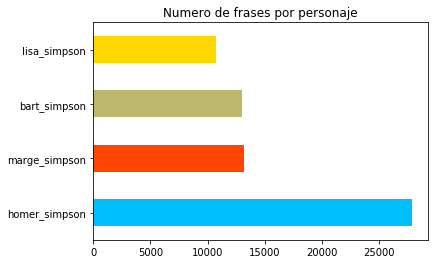

In [8]:
# Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [9]:
n_lines = frec.values[1]
n_lines

13172

Reducimos las frases para que todos los personajes tengan la misma cantidad.

In [10]:
np.random.seed(101)
homer_index = []

for i in range(len(labels)):
  if labels[i] == 'homer_simpson':
    homer_index.append(i)

homer_r = np.random.choice(homer_index,n_lines,replace=False)

In [11]:
np.random.seed(101)
marge_index = []

for i in range(len(labels)):
  if labels[i] == 'marge_simpson':
    marge_index.append(i)

In [12]:
np.random.seed(101)
bart_index = []

for i in range(len(labels)):
  if labels[i] == 'bart_simpson':
    bart_index.append(i)

In [13]:
np.random.seed(101)
lisa_index = []

for i in range(len(labels)):
  if labels[i] == 'lisa_simpson':
    lisa_index.append(i)

In [14]:
#seleccionamos las oraciones
sentences = np.array(sentences)
labels = np.array(labels)

homer_s = sentences[homer_r]
marge_s = sentences[marge_index]
bart_s = sentences[bart_index]
lisa_s = sentences[lisa_index]

homer_l = labels[homer_r]
marge_l = labels[marge_index]
bart_l = labels[bart_index]
lisa_l = labels[lisa_index]

In [15]:
#transformamos el formato
homer_s = homer_s.tolist()
marge_s = marge_s.tolist()
bart_s = bart_s.tolist()
lisa_s = lisa_s.tolist()

homer_l = homer_l.tolist()
marge_l = marge_l.tolist()
bart_l = bart_l.tolist()
lisa_l = lisa_l.tolist()

In [16]:
sentences = [homer_s + marge_s + bart_s + lisa_s]
np.shape(sentences)

(1, 50095)

In [17]:
labels = [homer_l + marge_l + bart_l + lisa_l]
np.shape(labels)

(1, 50095)

In [18]:
sentences = sentences[0]
labels = labels[0]

# Separa datos de entrenamiento y validación
### Aleatorización de los datos

In [19]:
# index to sample
n = len(sentences)
sentences = np.array(sentences)
labels = np.array(labels)

# index for sample for testing and training
np.random.seed(101)
sentences_id  = np.random.permutation(n)

# extract the samples
sentences = sentences[sentences_id] # Frases de validacion
labels = labels[sentences_id] # Frases de validacion

### Grupo de entrenamiento

In [20]:
train_size = int(len(sentences) * training_portion) # 80%

train_sentences = sentences[:train_size] # Frases de entrenamiento 
train_labels = labels[:train_size] # Etiquetas de entrenamiento
print("train_sentences:",len(train_sentences)) # Tamaño de frases de entrenamiento
print("train_labels:",len(train_labels),"\n") # Tamaño de etiquetas de entrenamiento

train_sentences: 40076
train_labels: 40076 



### Grupo de validación

In [21]:
validation_sentences = sentences[train_size:] # Frases de validacion
validation_labels = labels[train_size:] # Frases de validacion
print("validation_sentences:",len(validation_sentences)) # Tamaño de frases de validacion
print("validation_labels:",len(validation_labels),"\n") # Tamaño de etiquetas de validacion

validation_sentences: 10019
validation_labels: 10019 



In [22]:
#verificacion de tamaños
print("sentences:",len(sentences))
print("train_sentences + validation_labels:",len(train_sentences)+len(validation_sentences))

sentences: 50095
train_sentences + validation_labels: 50095


# Grafica de frecuencia de n-gramas
### Trigramas

In [23]:
#Juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

#Para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['and', 'you', 'will', 'be', 'a', 'dancer', 'hm', 'oh', 'so', 'now']

In [24]:
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['and you will', 'you will be', 'will be a', 'be a dancer', 'a dancer hm']

In [25]:
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens

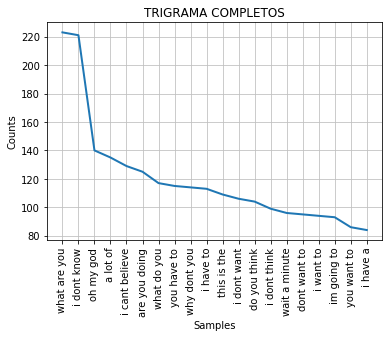

Trigramas completos unicos: 301121


In [26]:
# Gráfica con los trigramas COMPLETOS
freq.plot(20, cumulative=False, title = "TRIGRAMA COMPLETOS")
print("Trigramas completos unicos:", len(freq))

In [27]:
eliminar = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (250>val>3):
    eliminar.append(str(key))

trigrama_limpio = []
for i in trigrama:
  if i in eliminar:
    trigrama_limpio.append(i)

freqnew = nltk.FreqDist(trigrama_limpio)

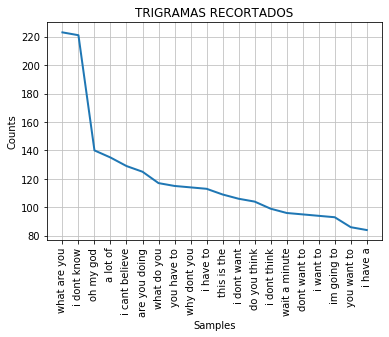

Trigramas recortados unicos: 6151


In [28]:
# Gráfica con los trigramas RECORTADOS
freqnew.plot(20, cumulative=False, title = "TRIGRAMAS RECORTADOS")
print("Trigramas recortados unicos:", len(freqnew))

In [29]:
#comparacion de trigramas
print("Trigramas completos unicos:", len(freq))
print("Trigramas recortados unicos:", len(freqnew))

Trigramas completos unicos: 301121
Trigramas recortados unicos: 6151


### Bigramas

In [30]:
bigrama = ngrams(tokenstk,2)
bigrama = [' '.join(grams) for grams in bigrama]
bigrama[:5]

['and you', 'you will', 'will be', 'be a', 'a dancer']

In [31]:
freqb = nltk.FreqDist(bigrama) #frecuencia de los tokens

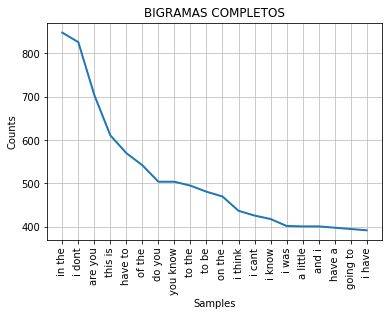

Bigramas completos unicos: 158197


In [32]:
# Gráfica con los bigramas COMPLETOS
freqb.plot(20, cumulative=False, title = "BIGRAMAS COMPLETOS")
print("Bigramas completos unicos:", len(freqb))

In [33]:
eliminarb = [] #filtramos tokens que se repiten mas de una vez
for key,val in freqb.items():
  if (700>val>100):
    eliminarb.append(str(key))

bigrama_limpio = []
for i in bigrama:
  if i in eliminarb:
    bigrama_limpio.append(i)

freqbnew = nltk.FreqDist(bigrama_limpio)

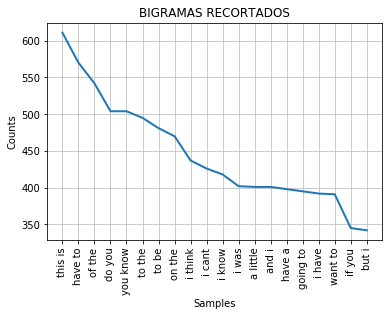

Bigramas recortados unicos: 228


In [34]:
# Gráfica con los Bigramas
freqbnew.plot(20, cumulative=False, title = "BIGRAMAS RECORTADOS")
print("Bigramas recortados unicos:", len(freqbnew))

In [35]:
#comparacion de bigramas
print("Bigramas completos unicos:", len(freqb))
print("Bigramas recortados unicos:", len(freqbnew))

Bigramas completos unicos: 158197
Bigramas recortados unicos: 228


# Vocabulario
### Trigramas

Aunque trigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqnew.keys() que contiene los tokens unicos.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(vocabulary=freqnew.keys(), ngram_range=(3,3))

In [37]:
X3 = vectorizer3.fit_transform(train_sentences)
X3

<40076x6151 sparse matrix of type '<class 'numpy.int64'>'
	with 32250 stored elements in Compressed Sparse Row format>

In [38]:
F3 = vectorizer3.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F3[:10]

['and you will',
 'will be a',
 'be a dancer',
 'but i dont',
 'i dont think',
 'think it would',
 'whats the matter',
 'the matter with',
 'with you homer',
 'we dont have']

In [39]:
train_sequences = X3.toarray() #arreglo
print("longitud",len(X3.toarray()))

longitud 40076


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a un trigrama, por lo tanto la tabla es de (55336 × 8616),

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias: 8616

In [40]:
import pandas as pd
pd.DataFrame(train_sequences,columns=vectorizer3.get_feature_names())

,and you will,will be a,be a dancer,but i dont,i dont think,think it would,whats the matter,the matter with,with you homer,we dont have,...,all a part,were number one,old folks home,cheated cheated cheated,shoo shoo shoo,me about the,me i got,gimme the bat,ba ba ba,four score and
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bigramas
Aunque bigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqbnew.keys() que contiene los tokens unicos.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(vocabulary=freqbnew.keys(), ngram_range=(2,2))

In [42]:
X2 = vectorizer2.fit_transform(train_sentences)
X2

<40076x228 sparse matrix of type '<class 'numpy.int64'>'
	with 28002 stored elements in Compressed Sparse Row format>

In [43]:
F2 = vectorizer2.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F2[:10]

['and you',
 'will be',
 'be a',
 'its a',
 'but i',
 'dont think',
 'with you',
 'dont have',
 'i want',
 'want to']

In [44]:
train_sequences_b = X2.toarray() #arreglo
print("longitud",len(X2.toarray()))

longitud 40076


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a un bigrama, por lo tanto la tabla es de (55336 × 319),

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias: 319

In [45]:
import pandas as pd
pd.DataFrame(train_sequences_b,columns=vectorizer2.get_feature_names())

,and you,will be,be a,its a,but i,dont think,with you,dont have,i want,want to,...,you dont,to me,of your,the way,at least,is it,way to,to take,you i,and the
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40073,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Datos Entrenamiento
### Juntamos los bigramas y trigramas
Como cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a los bigramas y trigramas, nuestra tabla es de (55336 × 9042) donde:

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias(8616) + bigramas unicos con sus frecuencias(319):  8935

In [46]:
print("Trigramas recortados unicos + Bigramas recortador unicos:", len(freqnew)+len(freqbnew))

Trigramas recortados unicos + Bigramas recortador unicos: 6379


In [47]:
train_sequences_bt = np.concatenate((train_sequences, train_sequences_b), axis=1)
#tamaño de los datos
type(train_sequences_bt)

numpy.ndarray

In [48]:
train_sequences_bt[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
train_sequences_bt_new = []
train_labels_new = []
for i in range(0,len(train_sequences_bt)):
  if sum(train_sequences_bt[i,]) != 0:
    train_labels_new.append(train_labels[i])
    train_sequences_bt_new.append(train_sequences_bt[i,])

train_sequences_bt = np.array(train_sequences_bt_new)

In [50]:
train_labels = train_labels_new
print("train_sequences_bt",np.shape(train_sequences_bt))
print("train_labels",np.shape(train_labels))

train_sequences_bt (21025, 6379)
train_labels (21025,)


# Datos Validacion
### Trigramas
Las columnas deben coincidir con los trigramas unicos (8616).

In [51]:
X6 = vectorizer3.fit_transform(validation_sentences)
validation_sequences = X6.toarray() #arreglo
print("shape",X6.toarray().shape)

shape (10019, 6151)


### Bigramas
Las columnas deben coincidir con los bigramas unicos (319).

In [52]:
X4 = vectorizer2.fit_transform(validation_sentences)
validation_sequences_b = X4.toarray() #arreglo
print("shape:",X4.toarray().shape)

shape: (10019, 228)


### Juntamos trigramas y bigramas
Vemos que las filas coinciden con numero de frases para validacion y que el numero de columnas (bigramas + trigramas) coindide con el numero de columnas de los datos de entrenamiento,

- train_sentences: 13835
- Trigramas unicos con sus frecuencias(8616) + bigramas unicos con sus frecuencias(319): 8935


In [53]:
validation_sequences_bt = np.concatenate((validation_sequences, validation_sequences_b), axis=1)
#tamaño de los datos
validation_sequences_bt.shape

(10019, 6379)

In [54]:
validation_sequences_bt_new = []
validation_labels_new = []
for i in range(0,len(validation_sequences_bt)):
  if sum(validation_sequences_bt[i,]) != 0:
    validation_labels_new.append(validation_labels[i])
    validation_sequences_bt_new.append(validation_sequences_bt[i,])

validation_sequences_bt = np.array(validation_sequences_bt_new)

In [55]:
validation_labels = validation_labels_new
print(np.shape(validation_sequences_bt))
print(np.shape(validation_labels))

(4879, 6379)
(4879,)


# Labels
### Entrenamiento

In [56]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(train_labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
training_label_seq[:5]
print(len(training_label_seq))

21025


In [57]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
train_labels = encoder.transform(training_label_seq)

In [58]:
# Codificación One-Hot 
num_classes = label_size
train_labels_codf = tf.keras.utils.to_categorical(train_labels, num_classes)

In [59]:
len(train_labels_codf)

21025

In [60]:
print(train_labels_codf)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


### Validacion 

In [61]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(validation_labels)
label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])
validation_label_seq
print(len(validation_label_seq))

4879


In [62]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
validation_labels = encoder.transform(validation_label_seq)
num_classes = 4

In [63]:
# Codificación One-Hot 
validation_labels_codf = tf.keras.utils.to_categorical(validation_labels, num_classes)

In [64]:
len(validation_labels_codf)

4879

In [65]:
print(validation_labels_codf)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


# Dividimos test y validación
Recordemos que el grupo de validacion (tanto las frases como los labels) que se ha tenido hasta ahora es el 20% de los datos iniciales, dividiremos este grupo es dos para tomar el 10% del total de los datos iniciales para la validacion interna y el otro 10% para la valicacion externa. Ademas tenga en cuenta que los porcentajes de datos son __aproximados__ debido a la transformacion y limpieza de los datos que se ha hecho.

Tomamos primero los datos de test(validacion externa) y luego los de validacion interna(validation_sequences_bt) porque renombraremos esa variable con el porcentaje de datos especificado arriba.

In [66]:
validation_portion = 0.5
validation_size = int(len(validation_sequences_bt) * validation_portion)
validation_size # 10% del total

test_sequences_bt = validation_sequences_bt[validation_size:] # Frases de test
test_labels_codf = validation_labels_codf[validation_size:] # Etiquetas de test

validation_sequences_bt = validation_sequences_bt[:validation_size] # Frases de validacion 
validation_labels_codf = validation_labels_codf[:validation_size] # Etiquetas de validacion

In [67]:
#verificacion de tamaños
print("validation_sequences_bt",validation_sequences_bt.shape) #validacion interna
print("validation_labels_codf",validation_labels_codf.shape)
print("test_sequences_bt",test_sequences_bt.shape) #validacion externa
print("test_labels_codf",test_labels_codf.shape)

validation_sequences_bt (2439, 6379)
validation_labels_codf (2439, 4)
test_sequences_bt (2440, 6379)
test_labels_codf (2440, 4)


# Construccion del Modelo

In [68]:
num_frases_training, num_ngrams, = np.shape(train_sequences_bt)

print("num_frases_training", num_frases_training) #se espera 29397
print("num_ngrams:", num_ngrams) #se espera 8935

num_frases_training 21025
num_ngrams: 6379


In [69]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4521, activation='relu', input_shape=(num_ngrams,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2261, activation='relu',
                         activity_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4521)              28843980  
_________________________________________________________________
dropout (Dropout)            (None, 4521)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2261)              10224242  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 9048      
Total params: 39,077,270
Trainable params: 39,077,270
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del modelo

|dropout|F. de activación| dense |loss_train |accuracy_train |loss_validation |accuracy_validation |Ephoc|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|4|tanh(1),relu(3)|5|0.7715|0.6028|1.2662|0.4657|7|
|4|tanh(4),relu(1)|6|0.9419|0.5285|1.1128|0.4241|6|
|5|tanh(2),relu(3)|6|0.7683|0.6877|1.7956|0.4490|10|
|5|tanh(0),relu(5)|6|0.4636|0.7820|2.1792|0.4489|10|
|4|tanh(0),relu(5)|6|0.5599|0.7633|1.7796|0.4444|7|
|3|tanh(3),relu(2)|6|0.5243|0.7608|2.0161|0.4381|9|
|4|tanh(5),relu(1)|7|0.9163|0.6148|1.3061|0.4359|5|
|4|tanh(5),relu(1)|7|1.0490|0.5492|1.1830|0.4670|5|
|4|tanh(1),relu(4)|7|0.9413|0.5382|1.0868 |0.4551|8|
|6|tanh(0),relu(7)|8|0.7479|0.6439|1.3333 |0.4498|6|
|1|tanh(0),relu(2)|3|0.5127|0.7513|1.7194 |0.4567|6|


In [71]:
num_epochs = 10
history = model.fit(train_sequences_bt, train_labels_codf, epochs=num_epochs, validation_data=(validation_sequences_bt,validation_labels_codf),batch_size=100, verbose=True, callbacks=[callback])

print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

Train on 21025 samples, validate on 2439 samples
Epoch 1/10
21025/21025 [==============================] - 157s 7ms/sample - loss: 1.0597 - accuracy: 0.4613 - val_loss: 1.0185 - val_accuracy: 0.4850
Epoch 2/10
21025/21025 [==============================] - 160s 8ms/sample - loss: 0.8994 - accuracy: 0.5707 - val_loss: 1.0548 - val_accuracy: 0.4682
Epoch 3/10
21025/21025 [==============================] - 150s 7ms/sample - loss: 0.7591 - accuracy: 0.6396 - val_loss: 1.1614 - val_accuracy: 0.4752
Epoch 4/10
21025/21025 [==============================] - 155s 7ms/sample - loss: 0.6477 - accuracy: 0.6987 - val_loss: 1.3363 - val_accuracy: 0.4625
Epoch 5/10
21025/21025 [==============================] - 151s 7ms/sample - loss: 0.5697 - accuracy: 0.7289 - val_loss: 1.4911 - val_accuracy: 0.4662
Epoch 6/10
21025/21025 [==============================] - 151s 7ms/sample - loss: 0.5127 - accuracy: 0.7513 - val_loss: 1.7194 - val_accuracy: 0.4567
Epoch 7/10
18000/21025 [========================>..

KeyboardInterrupt: 

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Prueba del modelo

In [ ]:
#predicciones del modelo
model.predict(test_sequences_bt)

In [ ]:
#etiquetas reales
test_labels_codf

# Funcion clasificadora

In [ ]:
def classifier (sentence): 
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)

  X = vectorizer3.fit_transform(sentence) 
  sentences_bt = X3.toarray() #codificacion para tabla con trigramas y bigramas

  prediction = model.predict_classes(sentences_bt)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [ ]:
classifier('can his funeral be on a school day')